# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

In [1]:
from unityagents import UnityEnvironment
from ddpg_agent import Agent

import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

TARGET_SCORE = 30.0
TARGET_EPISODES = 100

# Training Function

The function is used to train the Agents by interacting with environment and returns the training score. The training is considered to be completed once the Agents achieve a **average score > 30.0 over 100 episodes**.

In [3]:
def train_agent(n_episodes=2000, max_t=1000, noise = 1.0, noise_min = 0.01, noise_decay = 0.995):
    """Deep Deterministic Policy Gradients (DDPG).
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []      # Episode Scores
    avg_scores = []  # Average Episode Scores (MA)

    # Loop over Episodes
    for i_episode in range(1, n_episodes+1):
        agent.noise.reset()
        states = env.reset(train_mode=True)[brain_name].vector_observations
        scores_per_agent = np.zeros(num_agents)                      # Rewards for Episode per Agent

        for t in range(1, max_t+1):
            # Perform a step: S-A-R-S'
            actions = agent.act(states, noise_factor = noise)        # Select Next Action per Agent
            env_info = env.step(actions)[brain_name]                 # Send Action to Environment
            rewards = env_info.rewards                               # Collect Reward per Agent
            next_states = env_info.vector_observations               # Collect Next State per Agent
            dones = env_info.local_done                              # Collect Done per Agent
            agent.step(states, actions, rewards, next_states, dones) # Send Information to Agent    
            
            states = next_states
            scores_per_agent += rewards
            
            # Check if any of Agents finished the Episode
            if np.any(dones):
                break 
        
        noise = max(noise_decay*noise, noise_min)                    # Decay Noise per Episode
        
        # Store rewards to Lists
        scores.append(scores_per_agent.tolist())
        avg_scores.append(np.mean(scores[-TARGET_EPISODES:], axis=0))
        
        # Print Episode Score
        print('Episode {:3d} \tScore: {:5.2f} \tMoving average: {:5.2f}'.format(i_episode, scores_per_agent.mean(),
                                                                                avg_scores[-1].mean()))

        ## Check if Target has been reached
        if avg_scores[-1].mean() >= TARGET_SCORE and i_episode >= TARGET_EPISODES:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-TARGET_EPISODES,
                                                                                         avg_scores[-1].mean()))
            torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic.pth')
            break
            
    return scores, avg_scores

### 1. Start the Environment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_20Agent.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.90150833e+00 -1.00000000e+00
  1.25147629e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.22214413e-01]


### 3. Train the Agent

The cell trains the DQN Agent by utilizing **DDPG Algorithm** that contains the following components:

- Replay Buffer
- Ornstein-Uhlenbeck Process

After the cell is executed, the Agent is trained and the scores of the training are being return for plotting.

In [8]:
# Create the Agent
agent = Agent(state_size, action_size, 0)

print(agent.actor_local)
print('\n')
print(agent.critic_local)
print('\n')
print('Training Starts')
print('===============')

# Train the Agent
scores, moving_avg = train_agent()

Actor(
  (bn1d): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=4, bias=True)
)


Critic(
  (bn1d): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=132, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)


Training Starts
Episode   1 	Score:  0.01 	Moving average:  0.01
Episode   2 	Score:  0.08 	Moving average:  0.04
Episode   3 	Score:  0.11 	Moving average:  0.07
Episode   4 	Score:  0.24 	Moving average:  0.11
Episode   5 	Score:  0.89 	Moving average:  0.26
Episode   6 	Score:  0.87 	Moving average:  0.37
Episode   7 	Score:  0.80 	Moving average:  0.43
Episode   8 	Score:  0.86 	Moving average:  0.48
Episode   9 	Scor

Episode 156 	Score: 33.83 	Moving average: 17.13
Episode 157 	Score: 35.66 	Moving average: 17.48
Episode 158 	Score: 35.47 	Moving average: 17.82
Episode 159 	Score: 33.78 	Moving average: 18.14
Episode 160 	Score: 34.94 	Moving average: 18.48
Episode 161 	Score: 35.31 	Moving average: 18.82
Episode 162 	Score: 34.24 	Moving average: 19.14
Episode 163 	Score: 34.21 	Moving average: 19.47
Episode 164 	Score: 38.17 	Moving average: 19.83
Episode 165 	Score: 38.29 	Moving average: 20.19
Episode 166 	Score: 38.95 	Moving average: 20.56
Episode 167 	Score: 39.02 	Moving average: 20.93
Episode 168 	Score: 38.55 	Moving average: 21.29
Episode 169 	Score: 38.78 	Moving average: 21.64
Episode 170 	Score: 38.45 	Moving average: 21.99
Episode 171 	Score: 38.58 	Moving average: 22.33
Episode 172 	Score: 38.81 	Moving average: 22.68
Episode 173 	Score: 38.03 	Moving average: 23.02
Episode 174 	Score: 38.77 	Moving average: 23.38
Episode 175 	Score: 37.95 	Moving average: 23.72
Episode 176 	Score: 

### 4. Plot Agent Scores

The cell below plot the **Scores** and the **Average Scores** that Agent achieved per Episode during training.

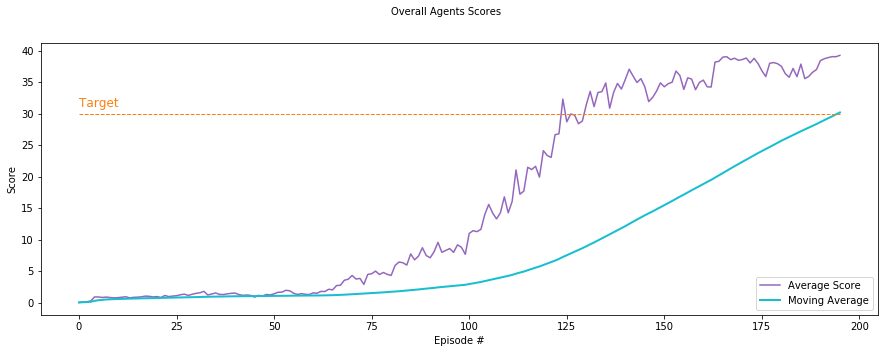

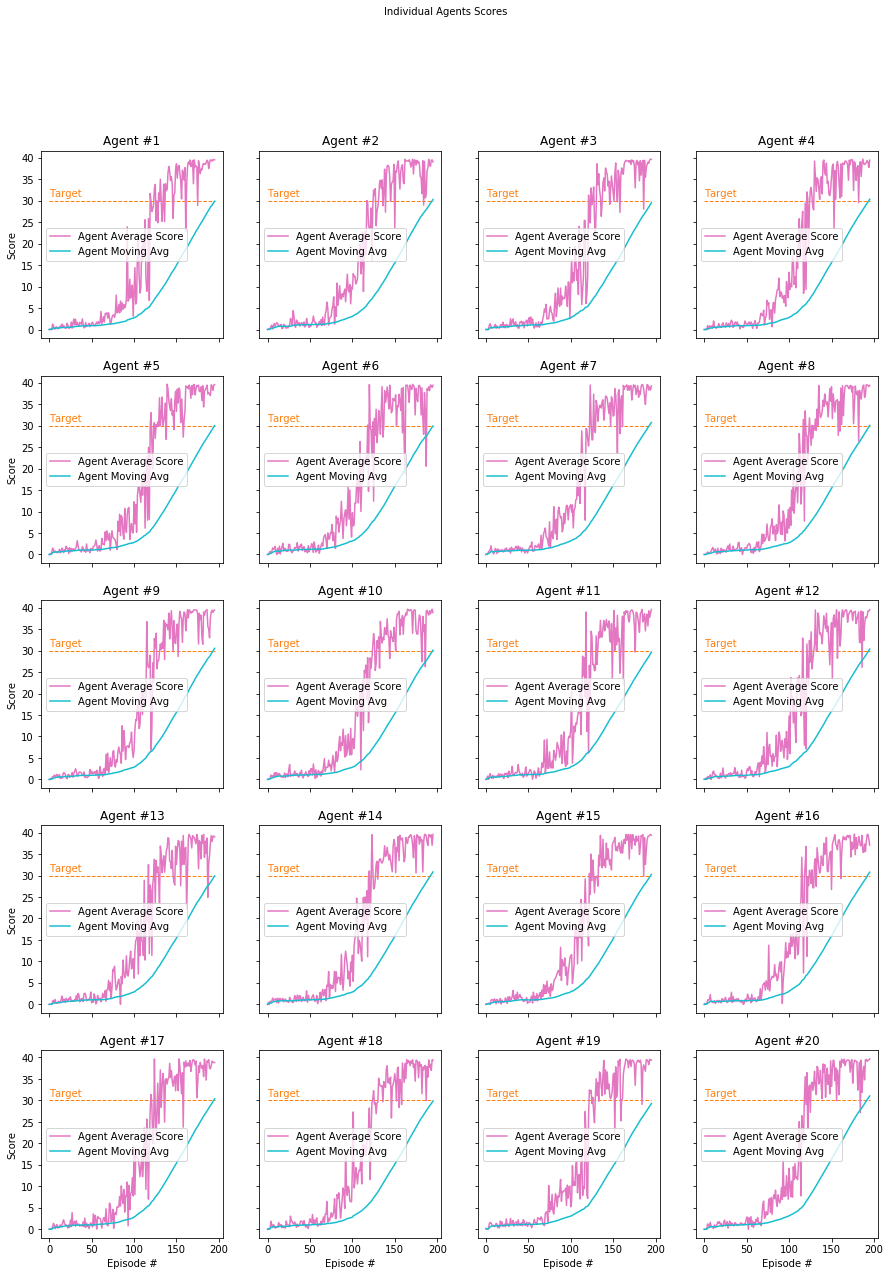

In [30]:
# Preprocess some variables
scores_mean = np.mean(scores, axis=1)
moving_avg_mean = np.mean(moving_avg, axis=1)
target = [TARGET_SCORE] * len(scores)           # Line for Target

# Plot Agents Scores
fig = plt.figure(figsize=(15,5))
fig.suptitle('Overall Agents Scores', fontsize='medium')

ax = fig.add_subplot(111)
ax.plot(scores_mean, label='Average Score', color='tab:purple')
ax.plot(moving_avg_mean, label='Moving Average', color='tab:cyan', linewidth=2)
ax.plot(target, linestyle='--', color='tab:orange', linewidth=1 )
ax.text(0, TARGET_SCORE+1, 'Target', color='tab:orange', fontsize='large')
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
ax.legend(fontsize='medium', loc='lower right')

plt.show()

# Plot Individual Agents Scores
fig, axs = plt.subplots(5, 4, figsize=(15, 20), sharex=True, sharey=True)
fig.suptitle('Individual Agents Scores', fontsize='medium')

axs = axs.flatten()
for idx, (ax, s, m) in enumerate(zip(axs, np.transpose(scores), np.transpose(moving_avg))):
    ax.plot(s, label='Agent Average Score', color='tab:pink', zorder=2)
    ax.plot(m, label='Agent Moving Avg', color='tab:cyan', zorder=3)
    ax.plot(target, linestyle='--', color='tab:orange', linewidth=1, zorder=0)
    ax.text(0, TARGET_SCORE+1, 'Target', color='tab:orange', fontsize='medium')

    ax.set_title('Agent #%d' % (idx+1))
    ax.set_ylabel('Score')
    ax.set_xlabel('Episode #')
    ax.label_outer()
    ax.legend(fontsize='medium')

plt.savefig('individual_agent_scores.png')

When finished, you can close the environment.

In [ ]:
env.close()

# Test the Trained Agent

In [3]:
# Test if Environment is Active
try:
    env
except:
    env = UnityEnvironment(file_name='Reacher_20Agent.app')
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    state_size = states.shape[1]
    action_size = brain.vector_action_space_size
    num_agents = len(env_info.agents)
    
# Load Agent Weights
agent = Agent(state_size, action_size, seed=0)
agent.actor_local.load_state_dict(torch.load('weights/checkpoint_actor.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('weights/checkpoint_critic.pth', map_location='cpu'))

# Observe Trained Agent in Environment
obs_episodes = 2
scores_episode = np.zeros(num_agents)
for ep in range(1, obs_episodes + 1):
    for i in range(1000):
        actions = agent.act(states, noise=False)
        env_info = env.step(actions)[brain_name]
        states = env_info.vector_observations
        rewards = env_info.rewards
        scores_episode += rewards

    print('Score for Episode {}: {:.2f}'.format(ep, scores_episode.mean()))